In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, json, time
from matplotlib_venn import venn2, venn3
from scipy import stats
from utility_functions import *

In [2]:
# ID rate analysis
def read_n_MS2_spectra(filename):
    spectra_path = os.path.join(working_folder, dataset_name, 'metadata') # NO! BAD!
    json_path = os.path.join(spectra_path, filename+'-metadata.json')  
    with open(json_path) as user_file:
        parsed_json = json.load(user_file)
    for entry in parsed_json['MsData']:
        if entry["name"] == "Number of MS2 spectra":
            return int(entry['value'])
    return np.nan

def calculate_id_rates(data):
    id_rates = pd.DataFrame(data.spectrum_file.value_counts()).reset_index()
    id_rates.columns = ['spectrum_file','num_ids']
    id_rates['msms_spectra'] = id_rates.spectrum_file.apply(read_n_MS2_spectra)
    id_rates['ID_rate'] = np.round(id_rates.num_ids / id_rates.msms_spectra, 2)
    return id_rates

In [3]:
working_folder = "C:/Users/Enrico/OneDrive - UGent/run-ionbot"
dataset_name = "PXD002057.v0.11.4"
# dataset_name = "PXD005833.v0.11.4"
# dataset_name = "PXD014258.v0.11.4"
dataset_closed = dataset_name.replace('.v0.11.4','-closed')

open_search_path   = os.path.join(working_folder, dataset_name,   f'{dataset_name}-openprot',   "combined-results-w-qvalues.csv.gz")
closed_search_path = os.path.join(working_folder, dataset_closed, f'{dataset_closed}-openprot', "combined-results-w-qvalues.csv.gz")

# filtering = 'custom'
# filtering = 'hybrid'
filtering = 'global'

closed_search = import_pep_IDs(closed_search_path, filtering=filtering)
open_search   = import_pep_IDs(open_search_path,   filtering=filtering)

In [4]:
# closed_search.tail()

In [5]:
# open_search.tail()

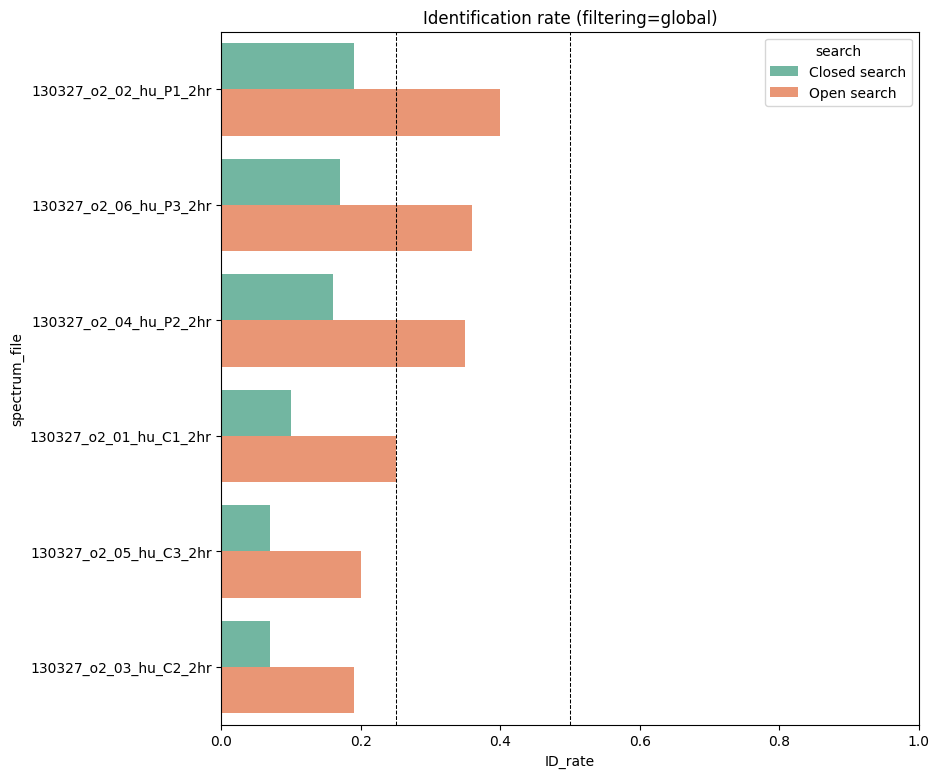

In [6]:
x1 = calculate_id_rates(closed_search)
x1['search'] = 'Closed search'

x2 = calculate_id_rates(open_search)
x2['search'] = 'Open search'

x = pd.concat((x1,x2), ignore_index=True)
# x.to_csv(os.path.join(working_folder, dataset_name, f'ID-rate-df-filt-{filtering}.csv'), index=False)

plt.figure(figsize=(9,9), facecolor='w')
sns.barplot(data=x, y='spectrum_file', x='ID_rate', hue='search', 
            # hue_order=['Canonical','Openprot','trEMBL'], 
            palette='Set2')
plt.xlim(0,1)
plt.axvline(.25, c='k', ls='--', lw=.75)
plt.axvline(.50, c='k', ls='--', lw=.75)
plt.title(f'Identification rate (filtering={filtering})')
plt.show()

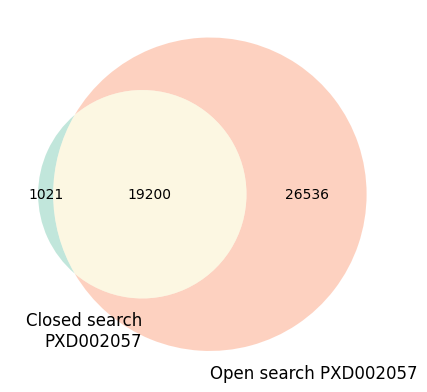

In [7]:
venn2([set(closed_search.spectrum_title),set(open_search.spectrum_title)], 
      set_labels=[f'Closed search\n{dataset_name[:9]}', 
                  f'Open search {dataset_name[:9]}'],
      set_colors=sns.color_palette("Set2")[:2])
# plt.title('Identified spectra overlap (PXD014258)')
plt.show()

In [8]:
open_search_features = pd.read_csv(os.path.join(working_folder, dataset_name, f'{dataset_name}-openprot',
                                             f'{dataset_name}-openprot-combined-features.csv.gz'))
print(open_search.shape, open_search_features.shape)
open_search_features = open_search.merge(open_search_features, on=['spectrum_title','scan','spectrum_file'])
print(open_search_features.shape)

closed_search_features = pd.read_csv(os.path.join(working_folder, dataset_closed, f'{dataset_closed}-openprot',
                                             f'{dataset_closed}-openprot-combined-features.csv.gz'))
print(closed_search.shape, closed_search_features.shape)
closed_search_features = closed_search.merge(closed_search_features, on=['spectrum_title','scan','spectrum_file'])
print(closed_search_features.shape)
# the length of the dfs should stay the same, otherwise something went wrong somewhere...

combo = closed_search_features.merge(open_search_features, on=['spectrum_title','spectrum_file','scan'], 
                                     # how='outer', 
                                     suffixes=['_closedsearch','_opensearch'])
print('Merged df size =', combo.shape)
# combo.to_csv(f'./publication-data/{dataset_name[:9]}-opensearch-x-closedsearch-filt-{filtering}.csv', index=False)
combo.to_csv(os.path.join(working_folder, dataset_name, f'{dataset_name[:9]}-opensearch-x-closedsearch-filt-{filtering}.csv.gz'),
             index=False, compression='gzip')

(45736, 17) (116596, 18)
(45736, 32)
(20221, 17) (77409, 18)
(20221, 32)
Merged df size = (19200, 61)


In [9]:
combo = closed_search_features.merge(open_search_features, on=['spectrum_title','spectrum_file','scan'], 
                                     how='outer', 
                                     suffixes=['_closedsearch','_opensearch'])
print('Merged df size =', combo.shape)
# combo.to_csv(f'./publication-data/{dataset_name[:9]}-opensearch-x-closedsearch-filt-{filtering}-outerjoin.csv', index=False)
combo.to_csv(os.path.join(working_folder, dataset_name, f'{dataset_name[:9]}-opensearch-x-closedsearch-filt-{filtering}-outerjoin.csv.gz'),
             index=False, compression='gzip')

Merged df size = (46757, 61)


-----

In [10]:
autosave(extra_labels='-'+dataset_name[:9]+'-'+filtering)
filtering, dataset_name

True


('global', 'PXD002057.v0.11.4')